In [17]:
import pyForwardFolding as pyFF
import pandas as pd
import yaml
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jax
import scipy

In [2]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")
ana = pyFF.config.analysis_from_config("test.yaml")

In [3]:
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [4]:
model = ana.expectations["det1"].model
be = ana.expectations["det1"]

In [5]:
model_parameters = {
    "powerlaw": {"flux_norm": 1.0, "spectral_index": 2.37},
    "atmo_norm": {"flux_norm": 1.0},
    "snowstorm_escale": {"sys_value": 1.0},
    "snowstorm_esmear": {"sys_value": 1.0},
    "delta_gamma": {"delta_gamma": 0.0}
}

In [6]:
input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "summary_stat": jnp.log10(jnp.asarray(data.reco_e))
}

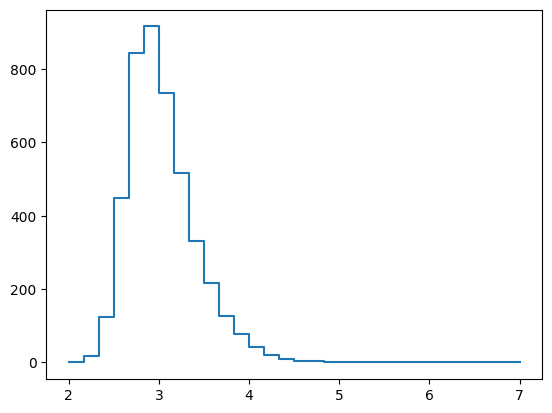

In [7]:
dataset = {"det1": input_variables}
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"].sum(axis=1)
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))


In [8]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
key = jax.random.PRNGKey(0)
obs = {}
for k, v in hist.items():
    key, subkey = jax.random.split(key)
    obs[k] = jax.random.poisson(subkey, v)
obs = hist # asimov

In [9]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)


In [10]:
def eval_for_par(par_val, par_dict):
    par_dict["snowstorm_escale"]["sys_value"] = par_val
    lh = lik.llh(obs, dataset, par_dict)
    return lh

val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0) )


The slowest run took 4.76 times longer than the fastest. This could mean that an intermediate result is being cached.
19.8 μs ± 15.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


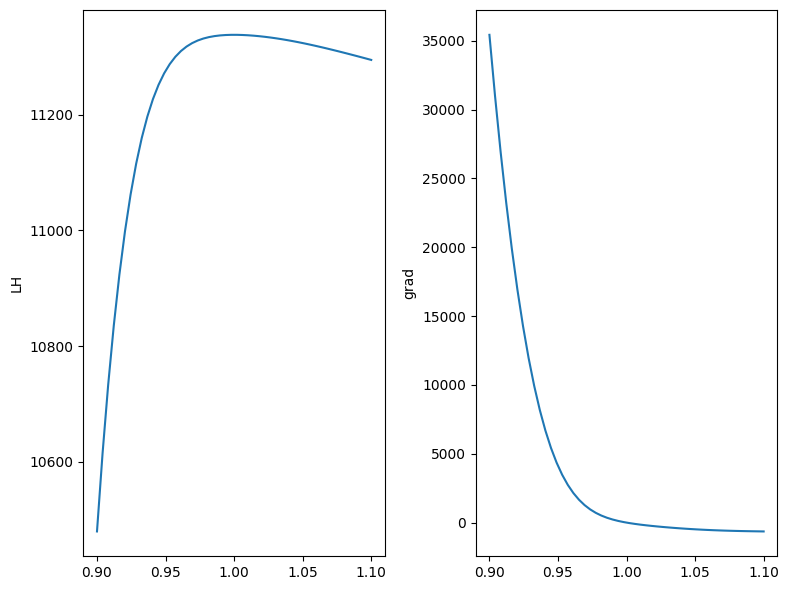

In [11]:
scan_vals = jnp.linspace(0.9, 1.1, 50)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None))(scan_vals, model_parameters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()

In [12]:
wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {})

In [13]:
pyFF.minimizer.flat_index_dict_mapping(ana.exposed_variables(), {})

{'powerlaw': {'flux_norm': 0, 'spectral_index': 1},
 'snowstorm_escale': {'sys_value': 2},
 'snowstorm_esmear': {'sys_value': 3},
 'atmo_norm': {'flux_norm': 4},
 'delta_gamma': {'delta_gamma': 5}}

In [22]:
fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))

In [49]:
import scipy.optimize

astro_scan = np.linspace(0, 3, 100)

scan_res = []

for astro in astro_scan:

    bounds = scipy.optimize.Bounds(
        [astro,      1.0, 0.9, 0.9, 0,      -1],
        [astro,      4.0, 1.1, 1.1, np.inf,  1]
    )

    res = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)
    scan_res.append(res.fun)

bounds = scipy.optimize.Bounds(
        [0,      1.0, 0.9, 0.9, 0,      -1],
        [np.inf,      4.0, 1.1, 1.1, np.inf,  1]
    )

free_fit = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)

Text(0, 0.5, 'Test Statistic')

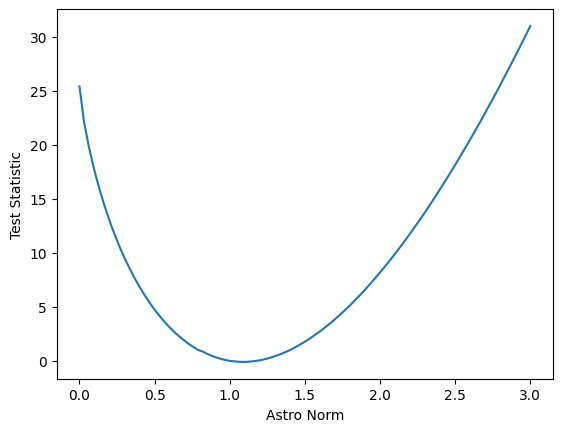

In [52]:
plt.plot(astro_scan, 2*(np.asarray(scan_res) - free_fit.fun))
plt.xlabel("Astro Norm")
plt.ylabel("Test Statistic")